# Experimental API: Basic tutorial

This tutorial demonstrates the usage of the new `Cows` object in the submodule `experimental`. The API of this class is not finalized yet, and may change without warning from version to version. The tutorial is a copy of the basic tutorial.

We will first cook up a toy model with a discriminant variable (invariant mass) and a control variable (decay time) and use it to generate some toy data.

Then we will use a fit to the invariant mass to obtain some component pdf estimates and use these to extract some weights which project out the signal only component in the decay time. 

We will demonstrate both the classic *sWeights* and the *Custom Ortogonal Weight functions* (COWs) method. See [arXiv:2112.04575](https://arxiv.org/abs/2112.04574) for more details.

In [1]:
from types import SimpleNamespace
from typing import Annotated

# external requirements
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

# from this package
from sweights.experimental import Cows
from sweights.testing import make_classic_toy # to generate a toy dataset
from sweights.util import plot_binned, make_weighted_negative_log_likelihood, FitValidation
from sweights.covariance import approx_cov_correct
import resample.bootstrap

## Toy model and toy data

We generate an m-distribution (for the discriminatory variable) and an independent t-distribution (the control variable). In particle physics, m is typically the invariant mass distribution of decay candidates, and t is the decay time distribution of these candidates. But any other two variables can be used, as long as they are independent in the pure signal and pure background.

In [2]:
# make a toy model
true_yield = SimpleNamespace()
true_yield.s = 1000
true_yield.b = 1000

# mass
mrange = (0, 1)
m_truth = SimpleNamespace()
m_truth.mu = 0.5
m_truth.sigma = 0.1
m_truth.slope = 1

# time
trange = (0, 1.5)
t_truth = SimpleNamespace()
t_truth.slope = 0.2
t_truth.mu = 0.1
t_truth.sigma = 1.0

toy = make_classic_toy(
    1,
    s=true_yield.s,
    b=true_yield.b,
    mrange=mrange,
    trange=trange,
    ms_mu=m_truth.mu,
    ms_sigma=m_truth.sigma,
    mb_mu=m_truth.slope,
    ts_mu=t_truth.slope,
    tb_mu=t_truth.mu,
    tb_sigma=t_truth.sigma,
)

## Make pdfs, plot ground truth and toy data 

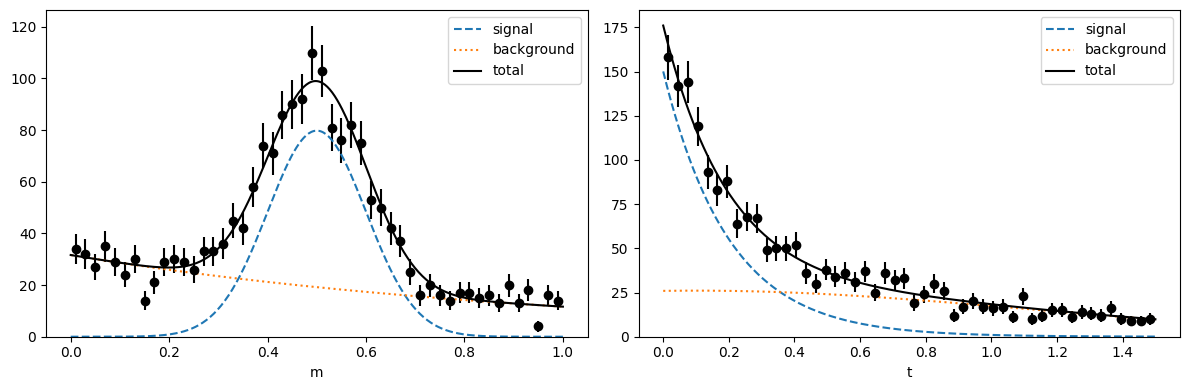

In [3]:
# m-density for fitting and plotting (not normalized)
def m_density(x, s, b, mu, sigma, slope):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))

    db = expon(mrange[0], slope)
    bnorm = np.diff(db.cdf(mrange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


# t-density for fitting and plotting (not normalized)
def t_density(x, s, b, slope, mu, sigma):

    ds = expon(trange[0], slope)
    snorm = np.diff(ds.cdf(trange))

    db = norm(mu, sigma)
    bnorm = np.diff(db.cdf(trange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


def plot(toy, bins=50, npoint=400, draw_pdf=True):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(ax[0])
    plot_binned(toy[0], bins=bins, range=mrange, color="k")
    plt.sca(ax[1])
    plot_binned(toy[1], bins=bins, range=trange, color="k")

    if draw_pdf:
        m = np.linspace(*mrange, npoint)
        mnorm = (mrange[1] - mrange[0]) / bins

        par = m_truth.mu, m_truth.sigma, m_truth.slope
        s = m_density(m, true_yield.s, 0, *par)
        b = m_density(m, 0, true_yield.b, *par)
        p = s + b

        ax[0].plot(m, mnorm * s, "C0--", label="signal")
        ax[0].plot(m, mnorm * b, "C1:", label="background")
        ax[0].plot(m, mnorm * p, "k-", label="total")

        t = np.linspace(*trange, npoint)
        tnorm = (trange[1] - trange[0]) / bins

        par = t_truth.slope, t_truth.mu, t_truth.sigma
        s = t_density(t, true_yield.s, 0, *par)
        b = t_density(t, 0, true_yield.b, *par)
        p = s + b

        ax[1].plot(t, tnorm * s, "C0--", label="signal")
        ax[1].plot(t, tnorm * b, "C1:", label="background")
        ax[1].plot(t, tnorm * p, "k-", label="total")

    ax[0].set_xlabel("m")
    ax[0].set_ylim(bottom=0)
    ax[0].legend()

    ax[1].set_xlabel("t")
    ax[1].set_ylim(bottom=0)
    ax[1].legend()

    fig.tight_layout()

plot(toy)

## Fully automated computation

You can compute sWeights fully automatically with the `Cows`. You only need to provide parametric models of the signal and background pdfs, and the sample in the m-variable. The `Cows` class will fit these pdfs to get their shapes and yields, and then construct the weights.

To make the fit succeed you either need good starting values for the parameters, or reasonable bounds for each parameter. Otherwise, the fit will fail. Parameter bounds are specified with a dictionary. An error is emitted if the fit fails, and a warning is emitted if the goodness-of-fit test fails. Either way, it is recommended to plot the normalizing function `norm`, which is the total pdf constructed from the signal and background pdfs. It should match the data density.

In [4]:
# We use annotated floats to tell iminuit which is used internally by the Cows class
# that the models have parameters with limits. This is convenient. If all parameters
# have bounds, you may not need to provide starting values. The Cows class will guess
# starting values based on the bounds. The slice notation is not standard, but terse
# and understood by iminuit.

def norm_par(x, mu: Annotated[float, 0:1], sigma: Annotated[float, 0:np.inf]):
    d = norm(mu, sigma)
    return d.pdf(x) / np.diff(d.cdf(mrange))


def expon_par(x, slope: Annotated[float, 0:np.inf]):
    d = expon(0, slope)
    return d.pdf(x) / np.diff(d.cdf(mrange))


cows0 = Cows(
    toy[0],
    norm_par,
    expon_par,
    ## visual check that normalizing function (Cows.norm) matches total density
    validation=FitValidation.DISPLAY
    ## You can also specify bounds like this:
    # bounds={
    #     norm_par: {"mu": (0, 1), "sigma": (0, np.inf)},
    #     expon_par: {"slope": (0, np.inf)},
    # },
    ## And you pass starting values like this:
    # starts={
    #   norm_par: {"mu": 0.4, "sigma": 0.2},
    #   expon_par: {"slope": 0.2}
    # },
    # yields=(1000, 1000)
)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.696e+04                 │              Nfcn = 138              │
│ EDM = 8.84e-05 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ yield[0] │    960    │    50     │            │            │    0    │         │       │
│ 1 │ mu       │  1.02e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ sigma    │   0.494   │   0.005   │            │            │    0    │    1    │       │
│ 3 │ yield[1] │   0.097   │   0.004   │            │            │    0    │         │       │
│ 4 │ slope    │   1.14    │   0.16    │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬────────────────────────────────────────────────────────┐
│          │   yield[0]         mu      sigma   yield[1]      slope │
├──────────┼────────────────────────────────────────────────────────┤
│ yield[0] │   2.12e+03     -1.2e3 -12.365e-3  90.869e-3     -1.014 │
│       mu │     -1.2e3   2.18e+03  12.364e-3 -90.868e-3      1.014 │
│    sigma │ -12.365e-3  12.364e-3   2.06e-05  -0.002e-3  -0.153e-3 │
│ yield[1] │  90.869e-3 -90.868e-3  -0.002e-3   1.86e-05  -0.069e-3 │
│    slope │     -1.014      1.014  -0.153e-3  -0.069e-3     0.0243 │
└──────────┴────────────────────────────────────────────────────────┘

## Fit toy data in the m-variable

If the fully automatic mode does not work for you, or if you want to have full control over the fit (for example, to accelerate it, or because you have a special case like weighted events), you should fit the shapes of the component pdfs manually.

We show next how to do that with `iminuit`. We use an extended unbinned maximum-likelihood fit here, but an extended binned maximum-likelihood fit would work as well, and so would an ordinary fit instead of an extended fit. The extended fits are easier to set up, however. Note that a binned fit can be much faster.

Again, you need to specify limits (bounds) to avoid stepping into parameter space where the pdf is not defined.

In [5]:
# m-model for an extended maximum-likelihood fit, must return...
# - integral as first argument
# - density as second argument
# see iminuit documentation for more information
def m_model(
    x,
    s: Annotated[float, 0 : np.inf],
    b: Annotated[float, 0 : np.inf],
    mu: Annotated[float, 0:1],
    sigma: Annotated[float, 0 : np.inf],
    slope: Annotated[float, 0 : np.inf],
):
    return (s + b, m_density(x, s, b, mu, sigma, slope))


mi = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=true_yield.s,
    b=true_yield.b,
    mu=m_truth.mu,
    sigma=m_truth.sigma,
    slope=m_truth.slope,
)
mi.strategy = 0
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.696e+04                 │              Nfcn = 75               │
│ EDM = 3.57e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │    960    │    50     │            │            │    0    │         │       │
│ 1 │ b     │  1.02e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ mu    │   0.494   │   0.005   │            │            │    0    │    1    │       │
│ 3 │ sigma │   0.097   │   0.004   │            │            │    0    │         │       │
│ 4 │ slope │   1.14    │   0.16    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma      slope │
├───────┼────────────────────────────────────────────────────────┤
│     s │   2.18e+03     -1.2e3  -5.500e-3  90.681e-3     -1.150 │
│     b │     -1.2e3   2.15e+03   7.385e-3 -91.851e-3      0.990 │
│    mu │  -5.500e-3   7.385e-3   2.19e-05  -0.002e-3  -0.175e-3 │
│ sigma │  90.681e-3 -91.851e-3  -0.002e-3   1.88e-05  -0.069e-3 │
│ slope │     -1.150      0.990  -0.175e-3  -0.069e-3     0.0247 │
└───────┴────────────────────────────────────────────────────────┘

From the fit result, we create the fixed estimated pdfs of the signal and background component, respectively.

In [6]:
def spdf(m):
    return norm_par(m, *mi.values["mu", "sigma"])


def bpdf(m):
    return expon_par(m, mi.values["slope"])


In the COWs computation, component pdfs are divided by the normalizing function $I(m)$. This function is arbitrary, but there is an optimal choice, which minimizes the variance of the weights. In case of factorizing signal and background PDFs, the optimal choice is $I(m) \propto g(m)$, where $g(m)$ is the estimated total density of in the discriminant variable m.  This choice together with the summation method to compute the W matrix gives classic sWeights. A solution close to optimal is to replace $g(m)$ with a histogram, with the advantage that $g(m)$ does not have to be explicitly constructed.

`Cows` class accepts a great variety of inputs and tries to use the best computation method given the inputs. For example, the summation method can only be used if the sample in the m-variable is passed as input. Otherwise, the integration method is used. The normalizing function $I(m)$ can be computed by the `Cows` class as before, explicitly provided as a function or histogram.

In [7]:
# unity (not optimal, but simple):
def norm_unit(x):
    return np.ones_like(x) / (mrange[1] - mrange[0])


# classic sWeights:
def norm_opt(m):
    return m_density(m, *mi.values) / (mi.values["s"] + mi.values["b"])


# histogram:
norm_hist = np.histogram(toy[0], bins=20, range=mrange)

# cows1 and 2 use the unit normalization function
cows1 = Cows(toy[0], spdf, bpdf, norm_unit)
cows2 = Cows(None, spdf, bpdf, norm_unit, range=mrange)
# cows3 is equivalent to classic sWeights
cows3 = Cows(toy[0], spdf, bpdf, norm_opt, summation=True)
# cows 4 and 5 use a histogram
cows4 = Cows(toy[0], spdf, bpdf, norm_hist)
cows5 = Cows(None, spdf, bpdf, norm_hist)
# cows6 is again equivalent to classic sWeights, norm_opt is computed internally
cows6 = Cows(toy[0], spdf, bpdf)
# cows7 is equivalent to classic sWeights, norm_opt is computed from provided yields
cows7 = Cows(toy[0], spdf, bpdf, yields=mi.values["s", "b"])

/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_75441/1764964862.py:15: CowsWarning: providing a sample and an external function with norm disables summation, override this with summation=True
  cows1 = Cows(toy[0], spdf, bpdf, norm_unit)


The warning is emitted in the computation of `cows1`, because the preferred summation method requires that the normalizing function $I(m)$ is an estimate of the total density in $m$. If you provide the normalization function manually, that cannot be ensured and the code chooses the integration method instead. You can override this automatic choice with `summation=True` or `summation=False`. Such an override is used in the computation of `cows3`.

## Comparison of COWs

We first compare the weight distributions.

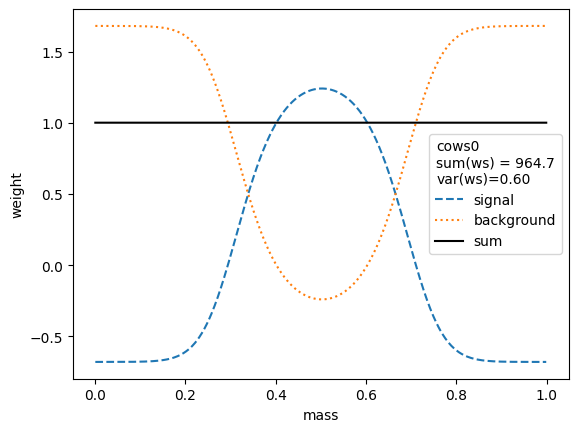

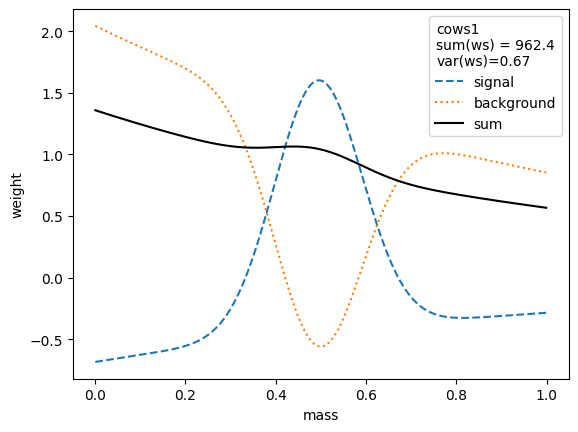

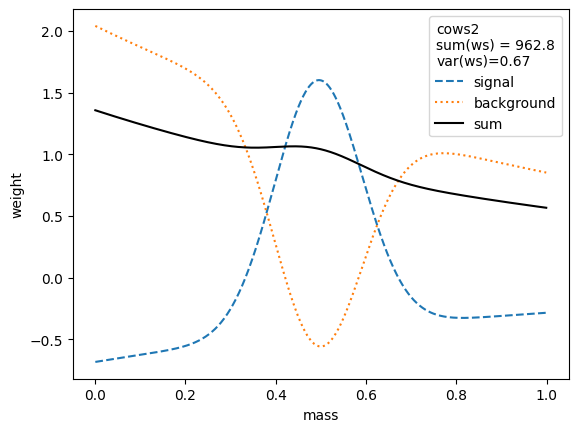

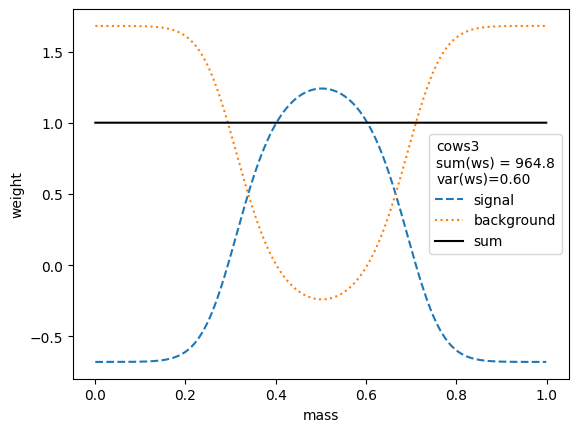

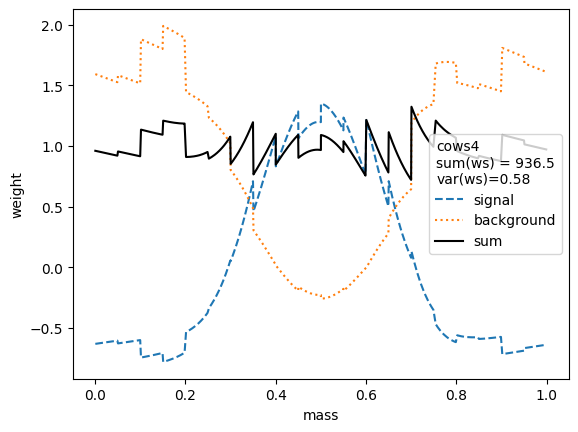

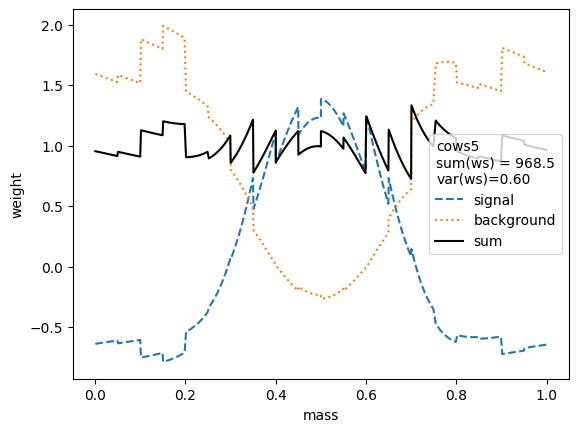

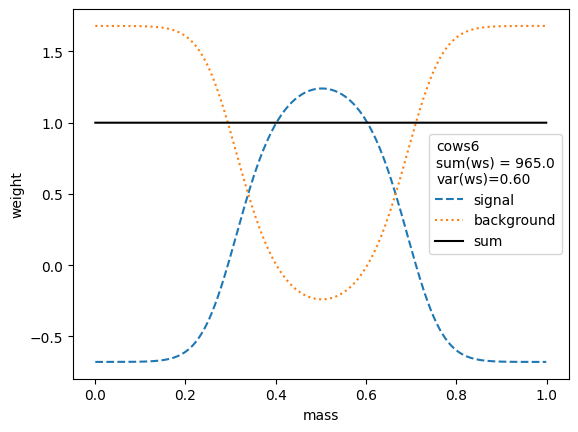

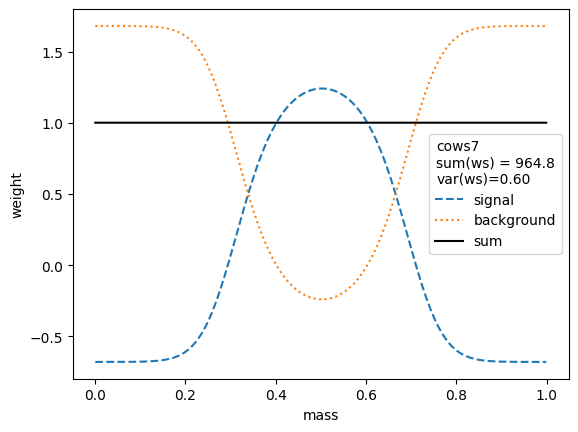

In [8]:
for i, weighter in enumerate([cows0, cows1, cows2, cows3, cows4, cows5, cows6, cows7]):
    # x = np.linspace(*mrange, 400)
    x = np.sort(toy[0])
    swp = weighter[0](x)
    bwp = weighter[1](x)

    plt.figure()
    plt.plot(x, swp, "C0--", label="signal")
    plt.plot(x, bwp, "C1:", label="background")
    plt.plot(x, swp + bwp, "k-", label="sum")
    plt.xlabel("mass")
    plt.ylabel("weight")
    plt.legend(title=(
        f"cows{i}\n"
        f"sum(ws) = {np.nansum(swp):.1f}\n"
        f"var(ws)={np.nanvar(swp):.2f}"))

The variance of the weights should be as small as possible. Ignoring the small variations in the second digit, we find that the variances for all variants are equivalent, except when the unity normalizing function is used, which performs worse. Only the classic sWeights technique guarantees self-consistency: the sum of the signal weights sums up to the fitted signal yield in the m-distribution. If you are only interested in the shape of the signal in the t-variable and not in the number density, then you can ignore this property.

All variants extract the signal in the control variable well.

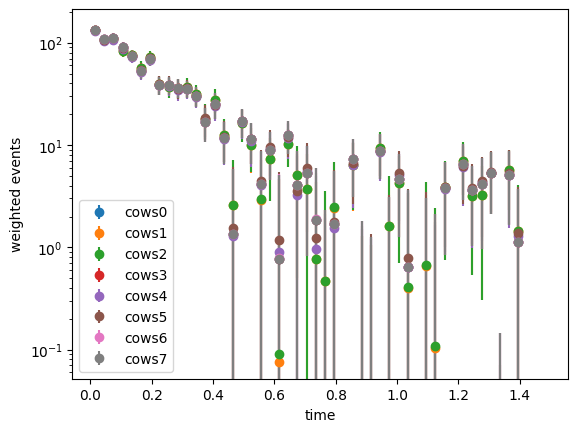

In [9]:
bins = 50
t = np.linspace(*trange, 400)

for i, weighter in enumerate([cows0, cows1, cows2, cows3, cows4, cows5, cows6, cows7]):
    w = weighter(toy[0])
    color = f"C{i}"
    plot_binned(
        toy[1],
        bins=bins,
        range=trange,
        weights=weighter(toy[0]),
        label=f"cows{i}",
        color=color,
    )

plt.legend()
plt.xlabel("time")
plt.ylabel("weighted events")
plt.semilogy();

The weights computed with all methods are rather similar. All expect `cows1` and `cows2` achieve minimum variance and are optimal.

Apart from plotting, you probably want to fit this distribution. There are some details that need to be considered. We will show that next.

### Fit weighted t-distribution

We proceed only with the weights from `cows0`, since the procedure is always the same.

In [10]:
# signal pdf in t-domain that we want to fit,
# the annotation tells iminuit that this parameter has limits 0,10
def t_signal_pdf(x, slope: Annotated[float, 0:10]):
    return t_density(x, 1, 0, slope, 0, 1)


# sweights to extract signal
w = cows0(toy[0])

# do the minimisation
tmi = Minuit(
    make_weighted_negative_log_likelihood(toy[1], w, t_signal_pdf),
    slope=0.1,
)
tmi.migrad()
# this won't give the correct error, because a weighted likelihood
# is not a real likelihood
tmi.hesse()
assert tmi.valid

# approximate correction takes weights into account, but
# neglects uncertainties in the COWs, which are also estimated
acov = approx_cov_correct(
    t_signal_pdf, toy[1], w, tmi.values, tmi.covariance, verbose=False
)

In [11]:

# To apply the bootstrap, we have to put the whole analysis into
# a function which takes the input sample and returns the final result
def fit(m, t):
    # we need to re-fit the signal and background pdfs each time
    cows = Cows(
        m,
        norm_par,
        expon_par,
        # it is okay to use the nominal results as starting values
        starts={
            norm_par: {"mu": mi.values["mu"], "sigma": mi.values["sigma"]},
            expon_par: {"slope": mi.values["slope"]},
        },
        # bootstrap fits tend to be slightly bad here, we skip validation
        # to avoid printing too many warnings and also to speed up
        validation=FitValidation.NONE
    )

    w = cows(m)

    # we fit the weighted t distribution
    tmi = Minuit(
        make_weighted_negative_log_likelihood(t, w, t_signal_pdf),
        slope=0.1,
    )
    tmi.migrad()
    return tmi.values["slope"]

# This takes a couple of seconds since the whole analysis is repeated 50 times.
# You should always use method="extended" in high energy physics, because
# the sample size in our experiments is a Poisson-distributed random number.
slope_var = resample.bootstrap.variance(
    fit, toy[0], toy[1], method="extended", size=50, random_state=1
)

In [12]:
print(
    f"naive           {tmi.values[0]:.3f} +/- {tmi.errors[0]:.3f}\n"
    f"approx. correct {tmi.values[0]:.3f} +/- {acov[0,0]**0.5:.3f}\n"
    f"bootstrap       {tmi.values[0]:.3f} +/- {slope_var**0.5:.3f}"
)

naive           0.202 +/- 0.007
approx. correct 0.202 +/- 0.017
bootstrap       0.202 +/- 0.019


The naive result is much too small and never correct, don't use it. In this case, approximately correct covariance is nearly identical to the full bootstrap variance, but that is not always the case.

## Write sWeights into a file

There are many ways to store the sweights for later use. In the Python world, you can just pickle the arrays. Or you can use Numpy's npz format. A slightly more organized way is to use a Pandas data frame. We show that option.

In [13]:
import pandas as pd

df = pd.DataFrame()
df['m'] = toy[0]
df['t'] = toy[1]
df['sweight_ws'] = cows0["s"](toy[0])
df['sweight_wb'] = cows0["b"](toy[0])
df

,m,t,sweight_ws,sweight_wb
0,0.927542,0.075108,-0.678789,1.678981
1,0.468974,0.005580,1.217351,-0.217471
2,0.449125,0.152979,1.180218,-0.180333
3,0.558792,0.079876,1.171350,-0.171463
4,0.400035,0.028505,0.992116,0.007800
...,...,...,...,...
1978,0.930051,1.093816,-0.678855,1.679047
1979,0.653689,0.081157,0.617723,0.382256
1980,0.382352,0.095900,0.881910,0.118025
1981,0.564565,1.170659,1.155715,-0.155826


Pandas data frames can be saved in multiple formats (see Pandas documentation). The feather format is particularly good.

However, in the particle physics world, you probably want to save the table as a ROOT file. This is easy with uproot. It will convert the data frame into a ROOT TTree automatically.

In [14]:
import uproot

with uproot.recreate('outf.root') as f:
   f['tree'] = df